# Visualizing Body Data
AMASS uses [MoSh++](https://amass.is.tue.mpg.de) pipeline to fit [SMPL+H body model](https://mano.is.tue.mpg.de/)
to marker based human motion capture (mocap) data.
[These mocaps](https://amass.is.tue.mpg.de) are from different publicly available datasets.
A single data file in amass has the parameters to control gender, pose, shape, global rotation, translation and soft tissue dynamics
in correspondence with the original motion capture sequence.
Here we present code snippets to render a body image with these parameters.
Mocap is a time sequence data, and you can visualize the "moshed" per frame results.

In [1]:
# Preparing the environment
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

In [2]:
import torch
import numpy as np

from human_body_prior.tools.omni_tools import copy2cpu as c2c
from os import path as osp

support_dir = '../support_data/'

In [3]:
# Choose the device to run the body model on.
comp_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We assume you have downloaded the required body model and placed them in body_models directory of this repository.
For SMPL+H body model, download it from http://mano.is.tue.mpg.de/.
Please download the AMASS version of the model with DMPL blendshapes.
You can obtain dynamic shape blendshapes, e.g. DMPLs, from http://smpl.is.tue.mpg.de.
In case, you use any of these models in your research please follow their respective citation rules.

In [4]:
amass_npz_fname = osp.join(support_dir, 'github_data/dmpl_sample.npz') # the path to body data
bdata = np.load(amass_npz_fname)

# you can set the gender manually and if it differs from data's then contact or interpenetration issues might happen
subject_gender = bdata['gender']

print('Data keys available:%s'%list(bdata.keys()))

print('The subject of the mocap sequence is  {}.'.format(subject_gender))

Data keys available:['poses', 'gender', 'mocap_framerate', 'betas', 'marker_data', 'dmpls', 'marker_labels', 'trans']
The subject of the mocap sequence is  male.


In [5]:
from human_body_prior.body_model.body_model import BodyModel

bm_fname = osp.join(support_dir, 'body_models/smplh/{}/model.npz'.format(subject_gender))
dmpl_fname = osp.join(support_dir, 'body_models/dmpls/{}/model.npz'.format(subject_gender))

num_betas = 16 # number of body parameters
num_dmpls = 8 # number of DMPL parameters

bm = BodyModel(bm_fname=bm_fname, num_betas=num_betas, num_dmpls=num_dmpls, dmpl_fname=dmpl_fname).to(comp_device)
faces = c2c(bm.f)


The provided sample data has the original mocap marker data.
In the real AMASS dataset, we include only markers for the test set.
For the rest of the subsets you can obtain the marker data from their respective websites.
In the following we make PyTorch tensors for parameters controlling different part of the body model.

**Note the indices for different body part pose.**

In [ ]:
time_length = len(bdata['trans'])

body_parms = {
    'root_orient': torch.Tensor(bdata['poses'][:, :3]).to(comp_device), # controls the global root orientation
    'pose_body': torch.Tensor(bdata['poses'][:, 3:66]).to(comp_device), # controls the body
    'pose_hand': torch.Tensor(bdata['poses'][:, 66:]).to(comp_device), # controls the finger articulation
    'trans': torch.Tensor(bdata['trans']).to(comp_device), # controls the global body position
    'betas': torch.Tensor(np.repeat(bdata['betas'][:num_betas][np.newaxis], repeats=time_length, axis=0)).to(comp_device), # controls the body shape. Body shape is static
    'dmpls': torch.Tensor(bdata['dmpls'][:, :num_dmpls]).to(comp_device) # controls soft tissue dynamics
}

print('Body parameter vector shapes: \n{}'.format(' \n'.join(['{}: {}'.format(k,v.shape) for k,v in body_parms.items()])))
print('time_length = {}'.format(time_length))

Import the required files for viewing out mesh:

In [7]:
import trimesh
from body_visualizer.tools.vis_tools import colors
from body_visualizer.mesh.mesh_viewer import MeshViewer
from body_visualizer.mesh.sphere import points_to_spheres
from body_visualizer.tools.vis_tools import show_image

imw, imh=1600, 1600
mv = MeshViewer(width=imw, height=imh, use_offscreen=True)

### Visualize betas and pose_body
Let's see how our body looks like using the pose and body shape parameters.
We first produce the body surface in batched mode.

Now we can visualize each frame of data

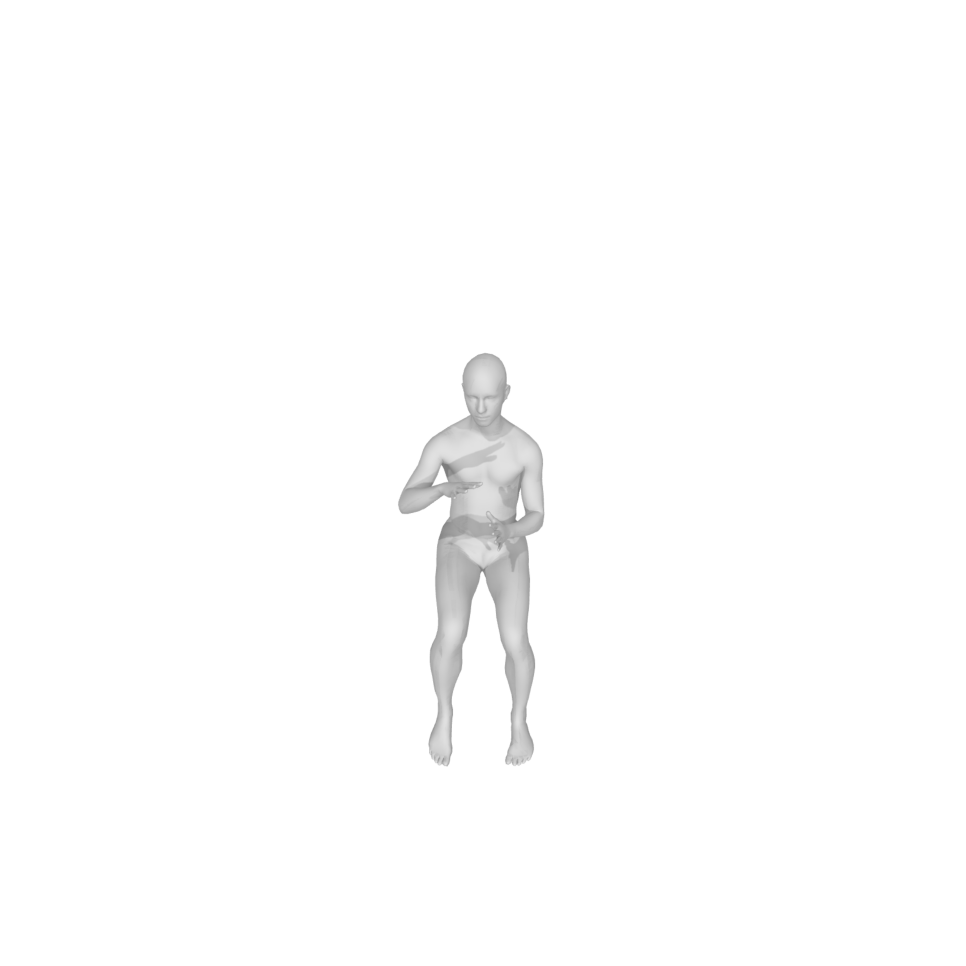

In [8]:
body_pose_beta = bm(**{k:v for k,v in body_parms.items() if k in ['pose_body', 'betas']})

def vis_body_pose_beta(fId = 0):
    body_mesh = trimesh.Trimesh(vertices=c2c(body_pose_beta.v[fId]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
    mv.set_static_meshes([body_mesh])
    body_image = mv.render(render_wireframe=False)
    show_image(body_image)

vis_body_pose_beta(fId=0)

We see a male subject sitting and havig the hands open.
Let's articulate the fingers as well:

### Visualize pose hands
To articulate fingers we use the 66:156 pose vector elements.

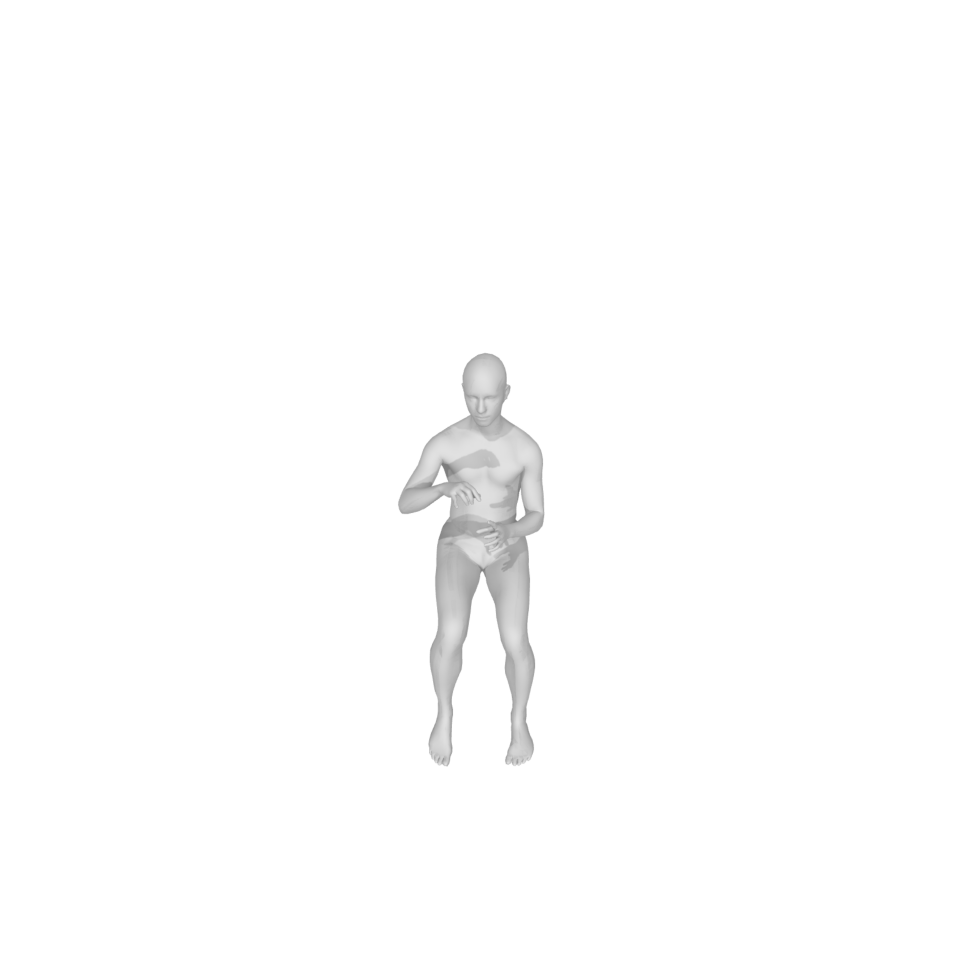

In [9]:
body_pose_hand = bm(**{k:v for k,v in body_parms.items() if k in ['pose_body', 'betas', 'pose_hand']})

def vis_body_pose_hand(fId = 0):
    body_mesh = trimesh.Trimesh(vertices=c2c(body_pose_hand.v[fId]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
    mv.set_static_meshes([body_mesh])
    body_image = mv.render(render_wireframe=False)
    show_image(body_image)

vis_body_pose_hand(fId=0)


It seems that the subject is holding something with one hand.

### Visualize body joints

To access joint locations of the body one can use **Jtr** attribute of the returned body.
These can be visualized as spheres.
Here we render the body transparently to visualize the joints.

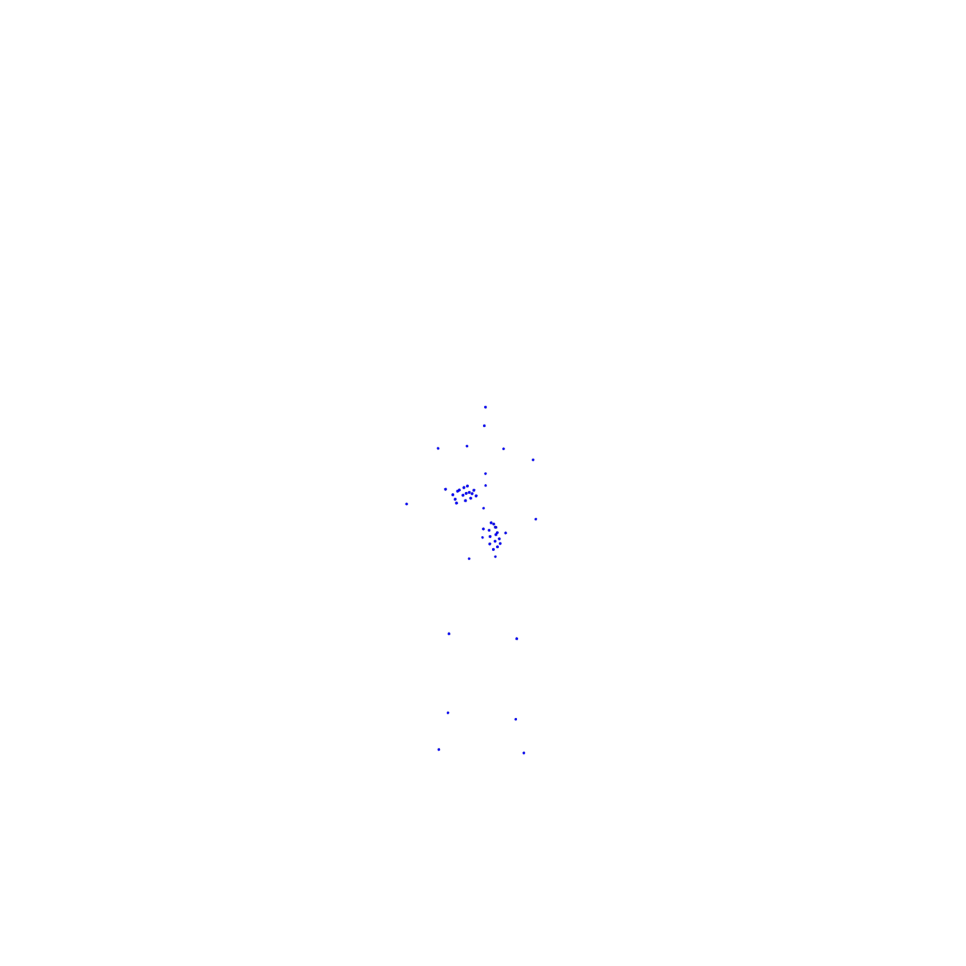

In [10]:
def vis_body_joints(fId = 0):
    joints = c2c(body_pose_hand.Jtr[fId])
    joints_mesh = points_to_spheres(joints, point_color = colors['red'], radius=0.005)

    mv.set_static_meshes([joints_mesh])
    body_image = mv.render(render_wireframe=False)
    show_image(body_image)

vis_body_joints(fId=0)


### Visualize DMPLs
You can control the soft tissue dynamics with DMPL parameters.
Please have in mind, to better visualize DMPLs you would need to render a sequence. Please refer to AMASS DMPL notebook for animation renders.
Refer to full renders of the parameter sequences in our [website](https://amass.is.tue.mpg.de/).

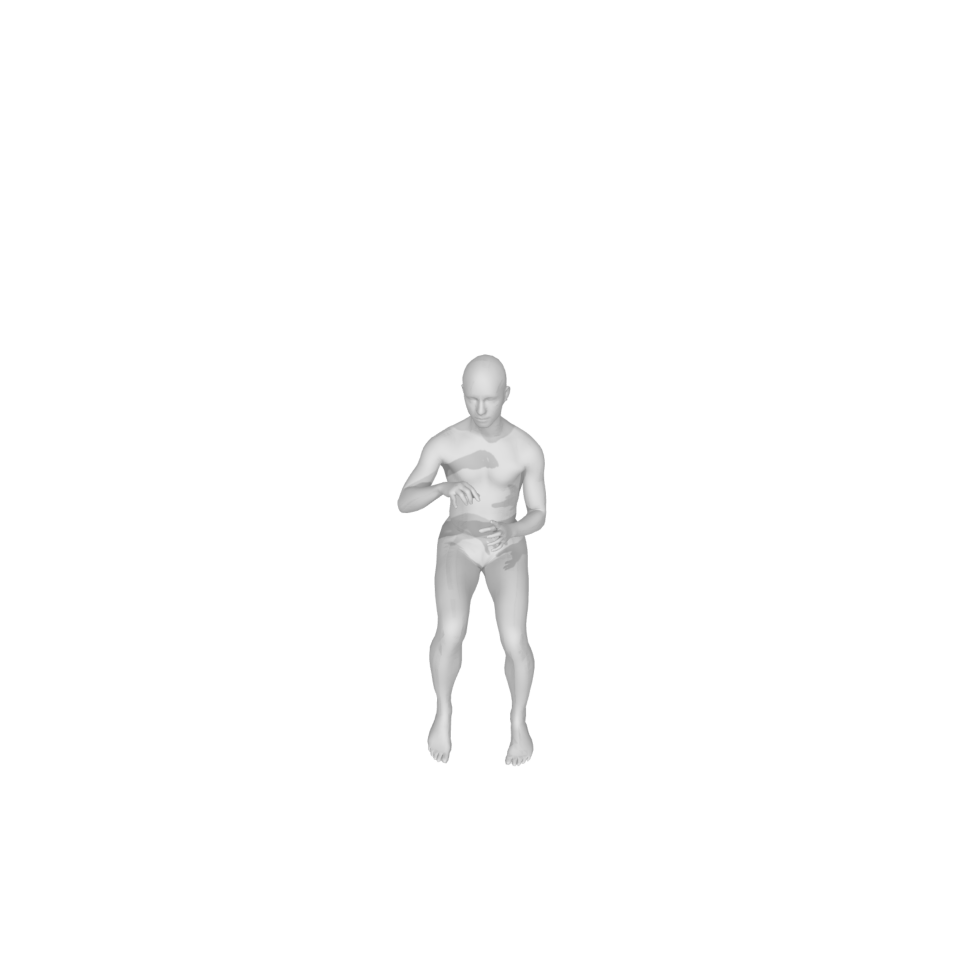

In [11]:
body_dmpls = bm(**{k:v for k,v in body_parms.items() if k in ['pose_body', 'betas', 'pose_hand', 'dmpls']})

def vis_body_dmpls(fId = 0):
    body_mesh = trimesh.Trimesh(vertices=c2c(body_dmpls.v[fId]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
    mv.set_static_meshes([body_mesh])
    body_image = mv.render(render_wireframe=False)
    show_image(body_image)

vis_body_dmpls(fId=0)

### Visualizing the global root orientation

In the above examples we don't use the global translation or rotation.
However, we can globally control the character position and orientation with **trans**, and **root_orient** parameters respectively.

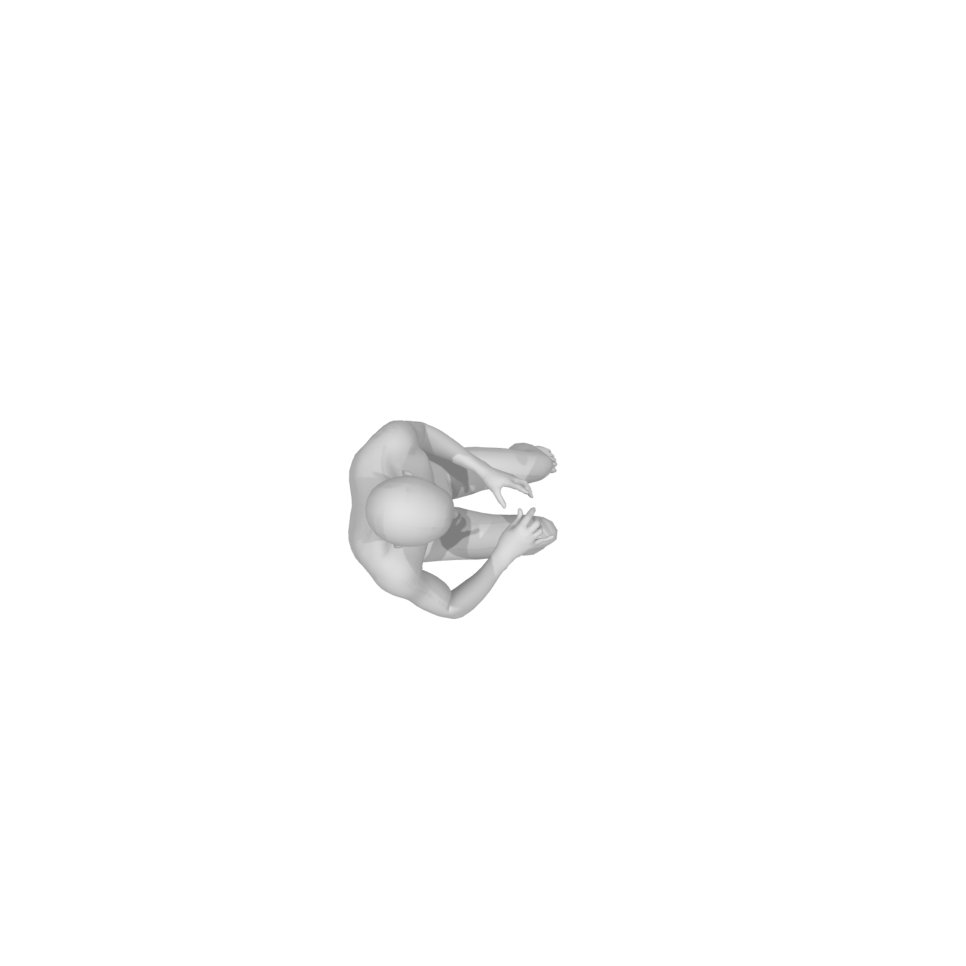

In [12]:
body_trans_root = bm(**{k:v for k,v in body_parms.items() if k in ['pose_body', 'betas', 'pose_hand', 'dmpls',
                                                                   'trans', 'root_orient']})

def vis_body_trans_root(fId = 0):
    body_mesh = trimesh.Trimesh(vertices=c2c(body_trans_root.v[fId]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
    mv.set_static_meshes([body_mesh])
    body_image = mv.render(render_wireframe=False)
    show_image(body_image)

vis_body_trans_root(fId=0)

The global root orientation of amass is so that if you render with MeshViewer you will always get a top view of the body.
One can rotate the body into front view by transforming the mesh.

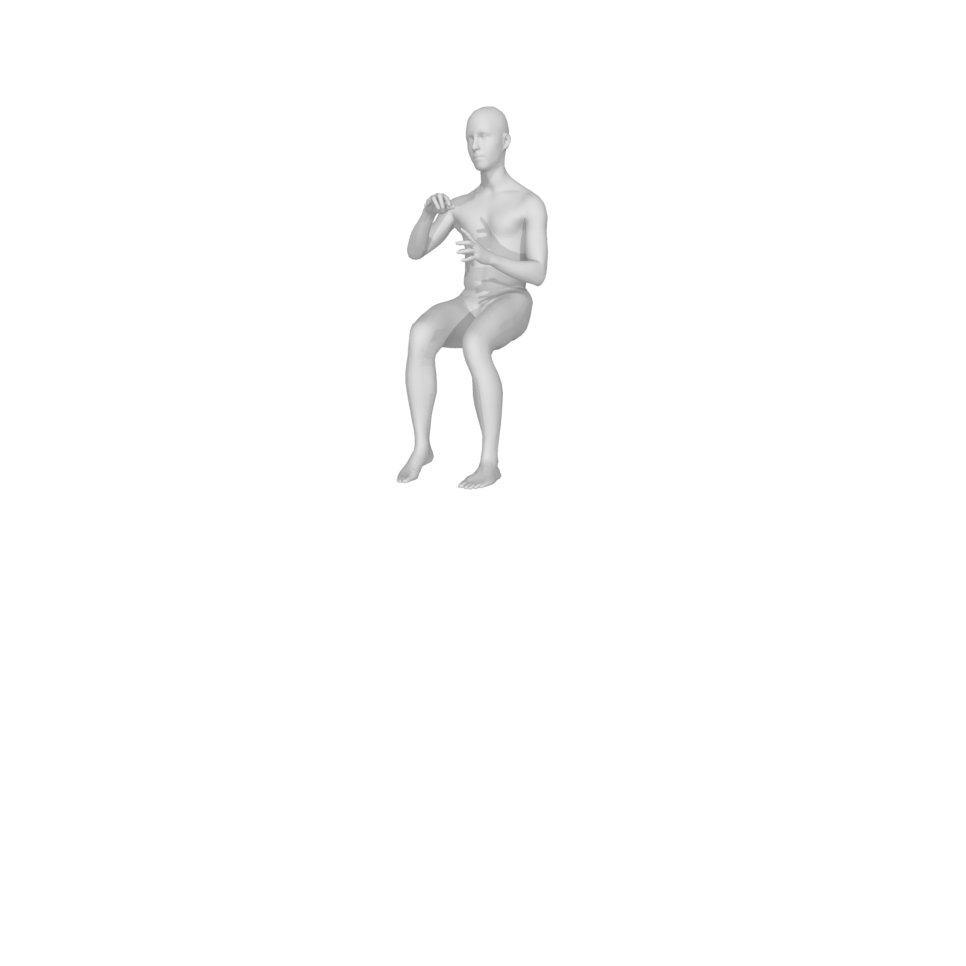

In [13]:
def vis_body_transformed(fId = 0):
    body_mesh = trimesh.Trimesh(vertices=c2c(body_trans_root.v[fId]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
    body_mesh.apply_transform(trimesh.transformations.rotation_matrix(-90, (0, 0, 1)))
    body_mesh.apply_transform(trimesh.transformations.rotation_matrix(30, (1, 0, 0)))

    mv.set_static_meshes([body_mesh])
    body_image = mv.render(render_wireframe=False)
    show_image(body_image)

vis_body_transformed(fId=0)